**ADA Milestone 2: Data collection and descriptive analysis**

In [36]:
#Imports
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import warnings
from IPython.display import Image

warnings.simplefilter('ignore')
PATH = './Data'

Some terms definition (cf https://offshoreleaks.icij.org/pages/faq#terms_definition):  
  
- Entity: A company, trust or fund created by an agent
- Officer: A person or company who plays a role in an offshore entity
- Intermediary: A go-between for someone seeking an offshore corporation and an offshore service provider
- Address: Contact postal address as it appears in the original databases obtained by ICIJ

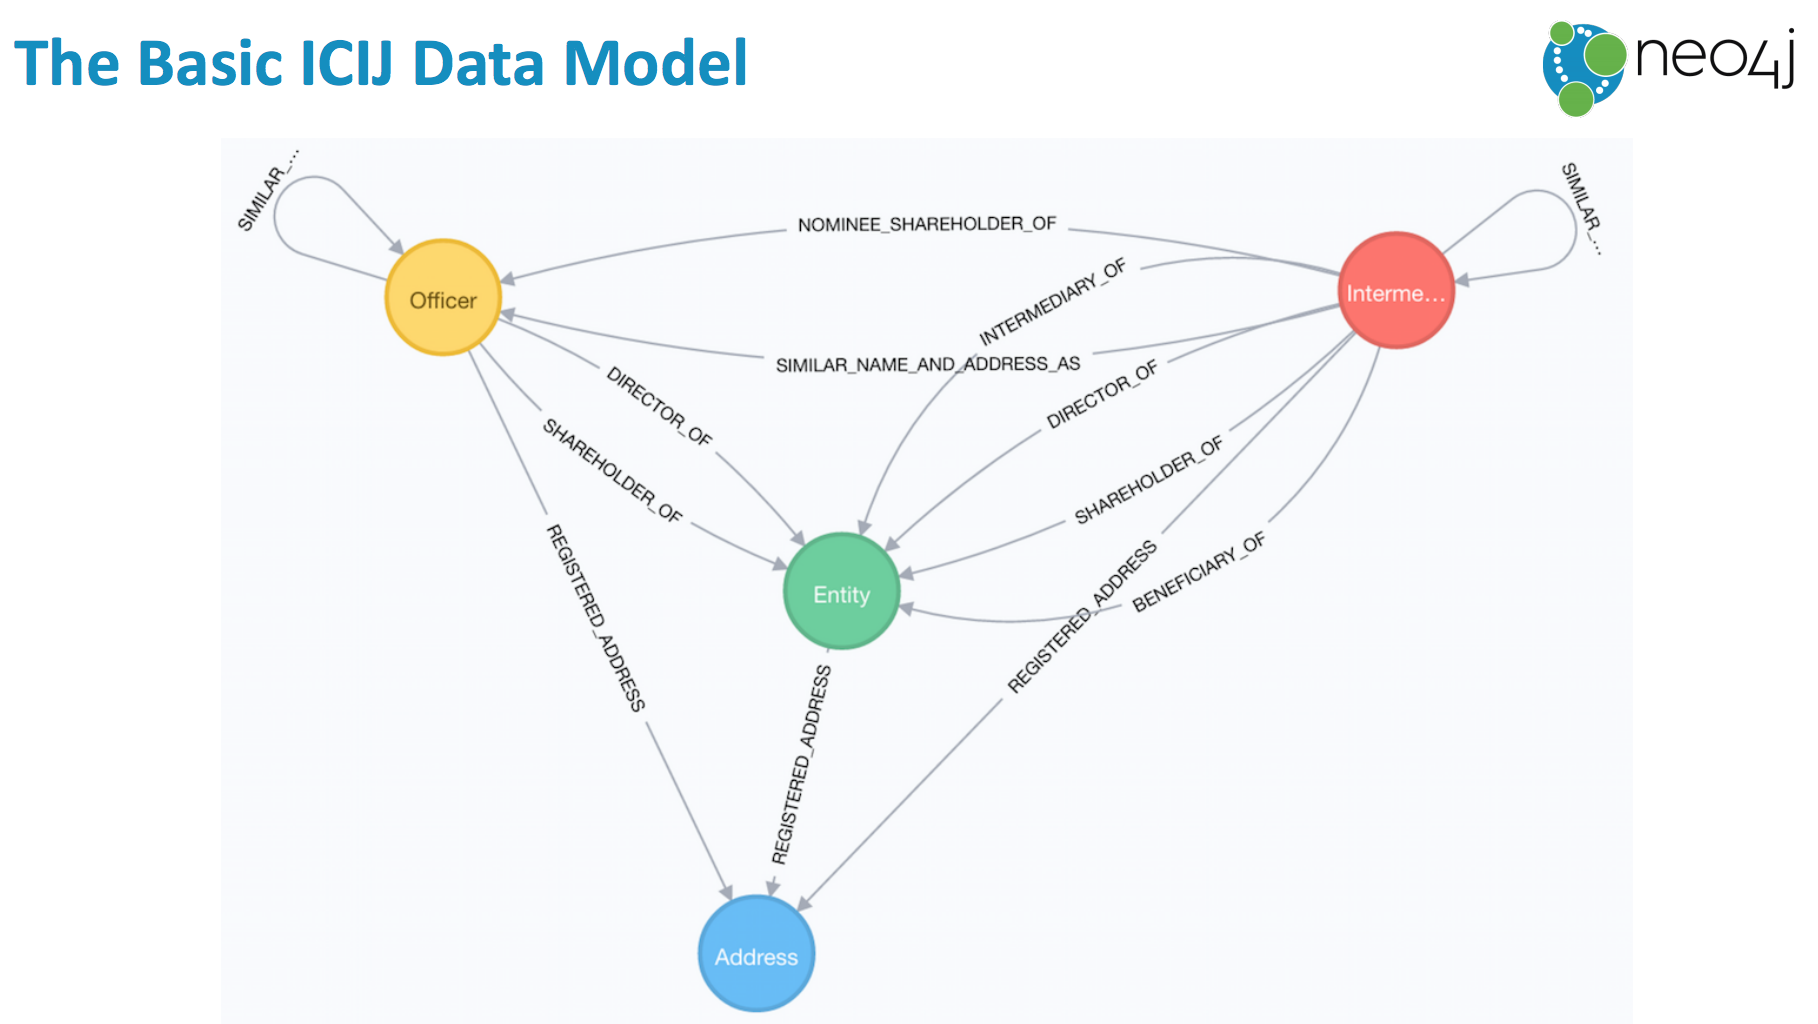

In [2]:
#The Panama Papers: Using open source tools for investigative journalism by Michael Hunger
Image(filename = PATH + "/Schema.png", width=700, height=700)

In [3]:
#Load each csv file into a dataframe
address = pd.read_csv(PATH+'/address.csv')
edges = pd.read_csv(PATH+'/edges.csv')
entity = pd.read_csv(PATH+'/entity.csv')
intermediary = pd.read_csv(PATH+'/intermediary.csv')
officer = pd.read_csv(PATH+'/officer.csv')

Inspection of the data reveals that some columns are either empty (note...) or contain redundant/useless information (valid_until, countries vs country_code...). Therefore we shall get rid of them.  
Moreover, we convert dates to the datetime format for further manipulations.  
We also observe that node ids in each dataframe are unique. However some node ids may appear twice for multiroles (officer/intermediary) actors.

Note that we may have to perform additional data transformation regarding names and addresses if need be.

In [4]:
#Drop useless columns
address.drop(['name', 'sourceID', 'valid_until', 'note', 'country_codes'], axis=1, inplace=True)
edges.drop(['sourceID', 'valid_until'], axis=1, inplace=True)
officer.drop(['sourceID', 'valid_until', 'note', 'country_codes'], axis=1, inplace=True)
intermediary.drop(['sourceID', 'valid_until', 'note', 'country_codes'], axis=1, inplace=True)
entity.drop(['closed_date', 'company_type', 'service_provider', 'sourceID', 'valid_until', 'note', 'country_codes', 'jurisdiction'], axis=1, inplace=True)

In [5]:
#Convert dates to datetime
entity['incorporation_date'] = pd.to_datetime(entity['incorporation_date'], format='%d-%b-%Y')
entity['inactivation_date'] = pd.to_datetime(entity['inactivation_date'], format='%d-%b-%Y')
entity['struck_off_date'] = pd.to_datetime(entity['struck_off_date'], format='%d-%b-%Y', errors='coerce')

Let's have a quick look at each dataframe

In [88]:
print('Address: {} entries'.format(address.size))
address.head()

Address: 280362 entries


,node_id,address,countries
0,14000001,-\t27 ROSEWOOD DRIVE #16-19 SINGAPORE 737920,Singapore
1,14000002,"""Almaly Village"" v.5, Almaty Kazakhstan",Kazakhstan
2,14000003,"""Cantonia"" South Road St Georges Hill Weybridg...",United Kingdom
3,14000004,"""CAY-OS"" NEW ROAD; ST.SAMPSON; GUERNSEY; CHANN...",Guernsey
4,14000005,"""Chirag"" Plot No 652; Mwamba Road; Kizingo; Mo...",Kenya


In [7]:
print('Edges:',edges.size,'entries')
edges.head()

Edges: 4044612 entries


,START_ID,TYPE,END_ID,link,start_date,end_date
0,10000035,registered_address,14095990,registered address,NaN,NaN
1,10000044,registered_address,14091035,registered address,NaN,NaN
2,10000055,registered_address,14095990,registered address,NaN,NaN
3,10000064,registered_address,14091429,registered address,NaN,NaN
4,10000089,registered_address,14098253,registered address,NaN,NaN


In [8]:
print('Entity:',entity.size,'entries')
entity.head()

Entity: 1922706 entries


,node_id,name,jurisdiction_description,countries,incorporation_date,inactivation_date,struck_off_date,ibcRUC,status
0,10000001,"TIANSHENG INDUSTRY AND TRADING CO., LTD.",Samoa,Hong Kong,2006-03-23,2013-02-18,2013-02-15,25221,Defaulted
1,10000002,"NINGBO SUNRISE ENTERPRISES UNITED CO., LTD.",Samoa,Hong Kong,2006-03-27,2014-02-27,2014-02-15,25249,Defaulted
2,10000003,"HOTFOCUS CO., LTD.",Samoa,Hong Kong,2006-01-10,2012-02-15,2012-02-15,24138,Defaulted
3,10000004,"SKY-BLUE GIFTS & TOYS CO., LTD.",Samoa,Hong Kong,2006-01-06,2009-02-16,2009-02-15,24012,Defaulted
4,10000005,FORTUNEMAKER INVESTMENTS CORPORATION,Samoa,Hong Kong,2006-04-19,2009-05-15,2008-02-15,R25638,Changed agent


In [9]:
print('Intermediary:',intermediary.size,'entries')
intermediary.head()

Intermediary: 56440 entries


,node_id,name,countries,status
0,11000001,"MICHAEL PAPAGEORGE, MR.",South Africa,ACTIVE
1,11000002,CORFIDUCIA ANSTALT,Liechtenstein,ACTIVE
2,11000003,"DAVID, RONALD",Monaco,SUSPENDED
3,11000004,"DE BOUTSELIS, JEAN-PIERRE",Belgium,SUSPENDED
4,11000005,THE LEVANT LAWYERS (TLL),Lebanon,ACTIVE


In [10]:
print('Officer',officer.size,'entries')
officer.head()

Officer 715206 entries


,node_id,name,countries
0,12000001,KIM SOO IN,South Korea
1,12000002,Tian Yuan,China
2,12000003,GREGORY JOHN SOLOMON,Australia
3,12000004,MATSUDA MASUMI,Japan
4,12000005,HO THUY NGA,Viet Nam


In [11]:
#Plot value counts
def plot_counts(title, data):
    plt.figure(figsize=(8,4))
    data.plot(kind='bar')
    plt.title(title)
    plt.ylabel("Count")
    plt.xticks(rotation=85)
    plt.plot()

**Let's obtain key figures about the Panama Papers**

**We start with entities**

Top 10 Number of offshore entities per jurisdiction

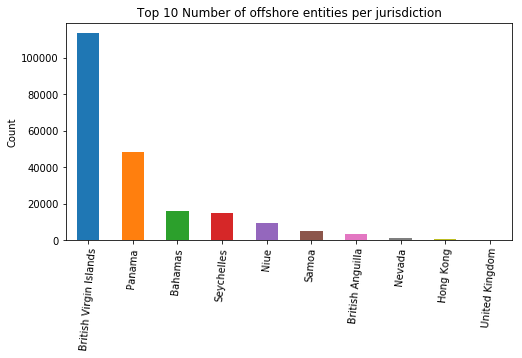

In [12]:
juris = entity['jurisdiction_description'].value_counts()
plot_counts("Top 10 Number of offshore entities per jurisdiction", juris[:10])

The most represented jurisdictions are tax heavens themselves. They act as intermediary countries for tax evasion. This is not good news since it will be much harder to extract relevant information about the largest countries involved.

Top 15 Number of offshore entities per country

One must make a distinction between country and jurisdiction:  
The difference between jurisdiction and country is that jurisdiction is the power, right, or authority to interpret and apply the law while country is (label) an area of land; a district, region. (cf https://wikidiff.com/jurisdiction/country)  


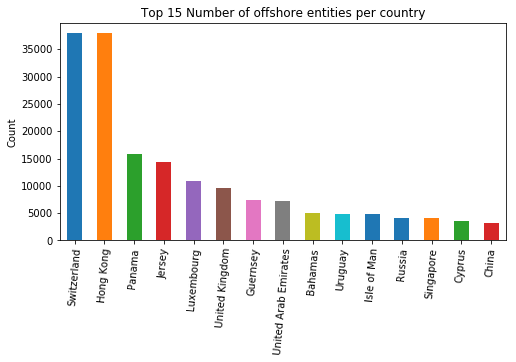

In [13]:
countries = entity['countries'].value_counts()
plot_counts("Top 15 Number of offshore entities per country", countries[:15])

Number of incorporated offshore companies per year

In [14]:
def plot_incorporated(data, title, lim=(1973,2017), ticks=range(1975, 2020, 5)):
    plt.figure(figsize=(10,5))
    data.loc[lim[0]:lim[1]].plot(kind='line')
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.xticks(ticks)
    plt.plot()

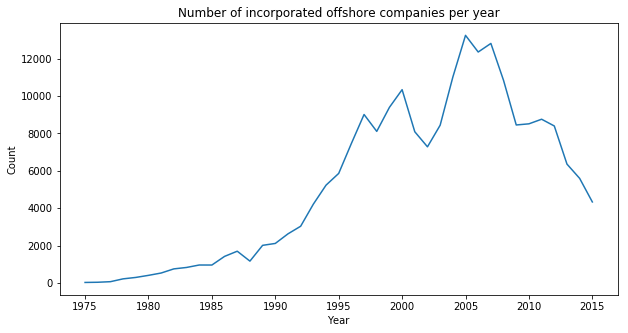

In [15]:
dates = entity['incorporation_date'].dt.year
incorp = dates[dates >= 1975].value_counts().sort_index()

plot_incorporated(incorp, 'Number of incorporated offshore companies per year')

Let's dig deeper into that graph: we locate interesting dips and peaks and try to link them to historical events.

-1970: For decades, offshore finance had a relatively modest profile in Panama. Nothing to report.

1975-2000: "But it took off in the 1970s as world oil prices surged. During this time, the Republic of Panama passed legislation entrenching corporate and individual financial secrecy." (Cf Wikipedia: Financial secrecy in Panama)


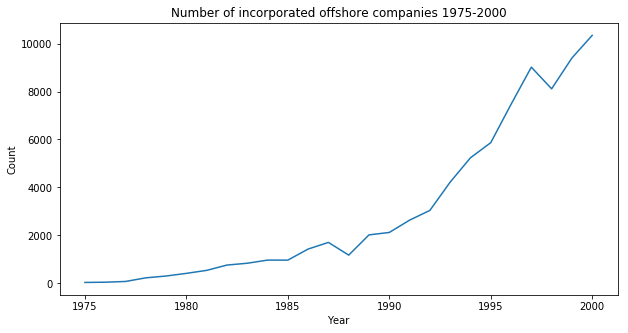

In [16]:
plot_incorporated(incorp, 'Number of incorporated offshore companies 1975-2000', (1975,2000))

1985-1990: Political crisis resulting in an invasion by the USA from 1989 to 1990. Notice the dip at that period

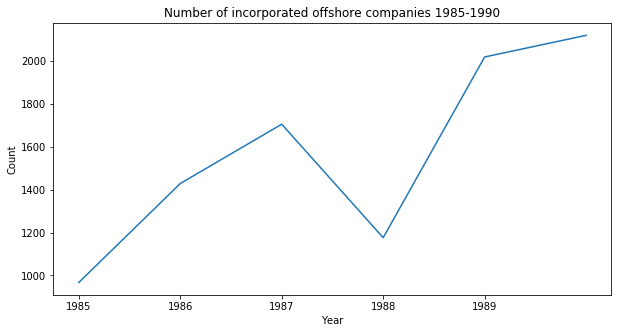

In [17]:
plot_incorporated(incorp, 'Number of incorporated offshore companies 1985-1990', (1985,1990), range(1985, 1990, 1))

2000-2005: "The 2000 OECD report, "Towards Global Tax Co-operation", included a list of 35 jurisdictions that were found to meet the tax haven criteria  set out in an earlier report issued in 1998." Guess who was listed ? Panama. This may explain another dip for 2 years.

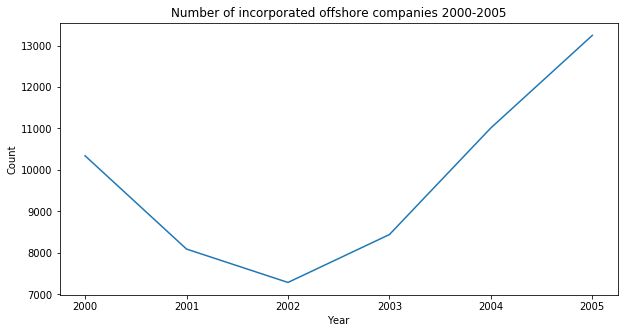

In [18]:
plot_incorporated(incorp, 'Number of incorporated offshore companies 2000-2005', (2000,2005), range(2000, 2006, 1))

2007-2015: The subprime crisis and the years after it. We notice a net decline in incorporated offshore companies during that period. One possible hypothesis would be that clients withdrew their assets for additional cash flows in their home countries.

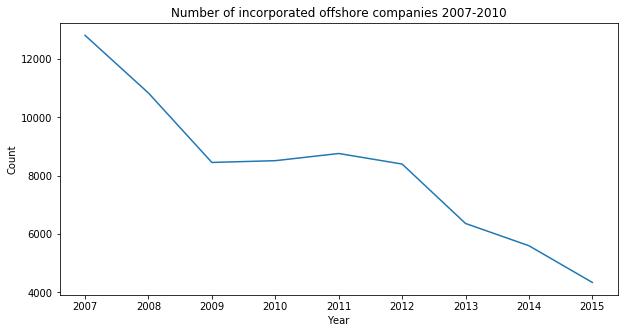

In [19]:
plot_incorporated(incorp, 'Number of incorporated offshore companies 2007-2010', (2007,2015), range(2007, 2016, 1))

This seems odd. In fact, one would expect the number of offshore entities to grow steadily following a financial crisis since "the offshore system offered and offers an offshore “get out of regulation free” card to financial businesses". (cf https://www.taxjustice.net/topics/finance-sector/tax-havens-financial-crisis/).  
Let's check the status of entities during that period.

[]

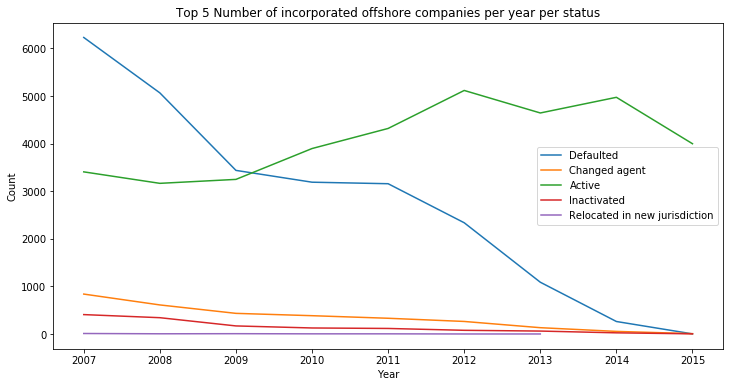

In [21]:
#Get status/dates dataframe then perform a groupby
status = entity.status.unique()
status_dates = pd.concat([entity['status'], dates], axis=1)
status_dates = status_dates[(status_dates['incorporation_date'] >= 2007)]
status_dates = status_dates.groupby(['status','incorporation_date']).size().reset_index()
status_dates.columns = ['status', 'incorporation_date', 'count']

plt.figure(figsize=(12,6))
for s in status[:5]:
    incor_status = status_dates[status_dates['status']==s]
    plt.plot(incor_status['incorporation_date'], incor_status['count'])  
plt.title('Top 5 Number of incorporated offshore companies per year per status')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(status[:5])
plt.xticks(range(2007, 2016, 1))
plt.plot()

Bingo. We observe that the number of active companies keeps increasing. This probably means that many new offshore companies were created while older inactivated/defaulted companies were put back into business. (Interpretation to check)

Number of incorporated offshore companies per year per jurisdiction

[]

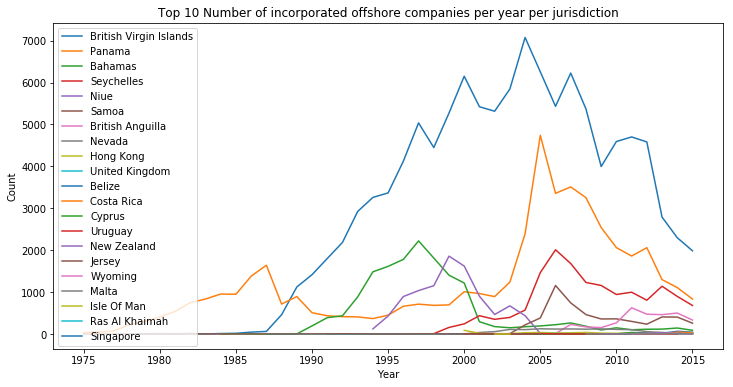

In [22]:
#Get data after 1970 and about the top 10 jurisdictions
juris_dates = pd.concat([entity['jurisdiction_description'], dates], axis=1)
juris_dates = juris_dates[(juris_dates['incorporation_date'] >= 1975) & (juris_dates['jurisdiction_description'].isin(juris.index))]
juris_dates = juris_dates.groupby(['jurisdiction_description','incorporation_date']).size().reset_index()
juris_dates.columns = ['jurisdiction_description', 'incorporation_date', 'count']

plt.figure(figsize=(12,6))
for j in juris.index:
    incor_juris = juris_dates[juris_dates['jurisdiction_description']==j]
    plt.plot(incor_juris['incorporation_date'], incor_juris['count'])  
plt.title('Top 10 Number of incorporated offshore companies per year per jurisdiction')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(juris.index)
plt.xticks(range(1975, 2020, 5))
plt.plot()

Number of incorporated offshore companies per year per country

[]

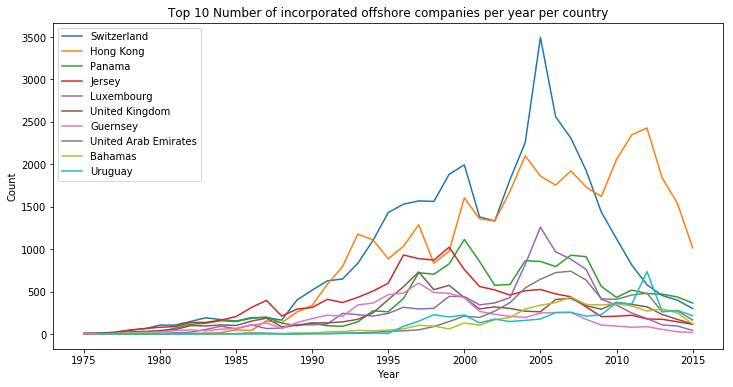

In [23]:
#Bis repetita of previous query
country_dates = pd.concat([entity['countries'], dates], axis=1)
country_dates = country_dates[(country_dates['incorporation_date'] >= 1975) & (country_dates['countries'].isin(countries.index[:10]))]
country_dates = country_dates.groupby(['countries','incorporation_date']).size().reset_index()
country_dates.columns = ['countries', 'incorporation_date', 'count']

plt.figure(figsize=(12,6))
for c in countries.index[:10]:
    incor_country = country_dates[country_dates['countries']==c]
    plt.plot(incor_country['incorporation_date'], incor_country['count'])  
plt.title('Top 10 Number of incorporated offshore companies per year per country')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(countries.index[:10])
plt.xticks(range(1975, 2020, 5))
plt.plot()

**We continue with intermediaries**

Top 15 Number of intermediaries per country

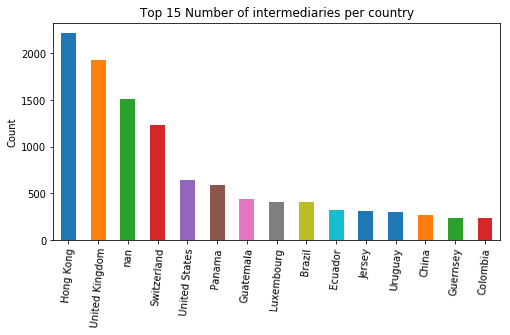

In [24]:
#First we need to explode the countries column since one intermediary may have multiple countries
inter_countries = intermediary['countries'].astype(str).apply(lambda s: s.split(';'))
inter_countries = inter_countries.apply(pd.Series).stack().reset_index(drop=True)
inter_countries = inter_countries.value_counts()

plot_counts("Top 15 Number of intermediaries per country", inter_countries[:15])

It looks like that entities and intermediaries locations are correlated. That is countries host both entities and intermediaries. However we observe that some of the largest countries display a significant number of intermediaries (while they are lacking in number of entities). We shall put this hypothesis to the test when we tackle officers.

Distribution of intermediaries' status

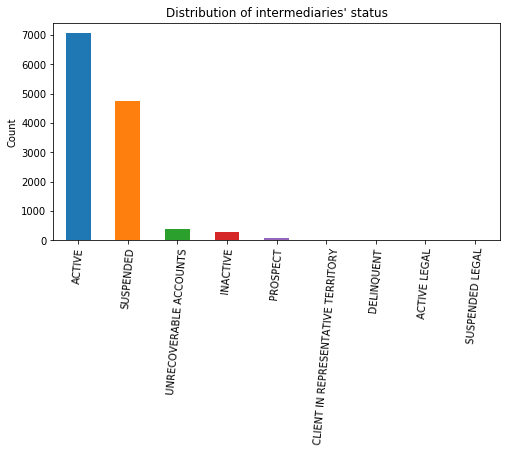

In [25]:
inter_status = intermediary['status'].value_counts()
plot_counts("Distribution of intermediaries' status", inter_status)

Intermediaries that requested the most offshore companies creations

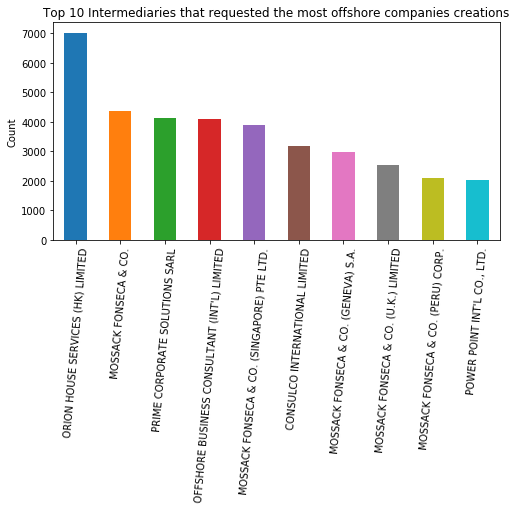

In [26]:
requests_ids = edges[edges.TYPE == 'intermediary_of'].START_ID.to_frame()
most_requests = requests_ids.merge(intermediary, left_on='START_ID', right_on='node_id')
counts_requests = most_requests['name'].value_counts()

plot_counts("Top 10 Intermediaries that requested the most offshore companies creations", counts_requests[:10])

In the next milestone we will dig a bit deeper into the swiss intermediaries involved. We will see that they rank quite high in the hierarchy.

**We investigate the possible relationships between "nodes"**

Top 5 Number of links between nodes

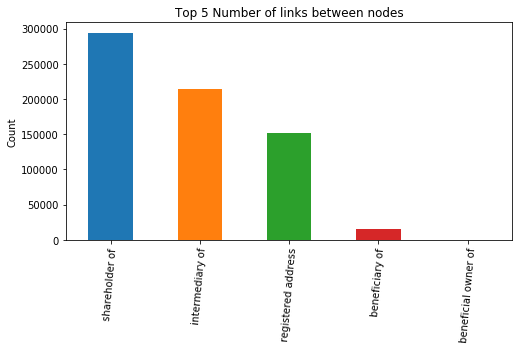

In [27]:
links = edges['link'].value_counts()

plot_counts("Top 5 Number of links between nodes", links[:5])

**Officers here we come**

Top 15 Number of officers per country

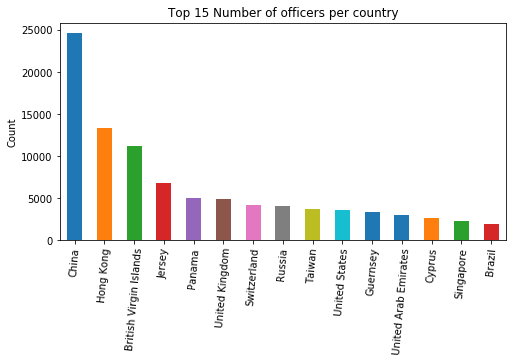

In [28]:
off_countries = officer['countries'].value_counts()

plot_counts("Top 15 Number of officers per country", off_countries[:15])

Let's put the hypothesis that the number of entities per country is correlated with the number of intermediaries/officers to the test.  
Since we can't assume a normal distribution (the distribution of nodes degrees in general is most likely a pseudo power-law which we will see) we will resort to the spearman rank-order correlation.

In [83]:
entity_officer = pd.concat([countries, off_countries], axis=1).dropna(how='any')
corr_entity_officer = st.spearmanr(entity_officer.iloc[:,0], entity_officer.iloc[:,1])

In [84]:
entity_intermediary = pd.concat([countries, inter_countries], axis=1).dropna(how='any')
corr_entity_intermediary = st.spearmanr(entity_intermediary.iloc[:,0], entity_intermediary.iloc[:,1])

In [85]:
officer_intermediary = pd.concat([off_countries, inter_countries], axis=1).dropna(how='any')
corr_officer_intermediary = st.spearmanr(officer_intermediary.iloc[:,0], officer_intermediary.iloc[:,1])

In [87]:
print('Entity/Intermediary Correlation: {} p value: {}'.format(corr_entity_intermediary[0], corr_entity_intermediary[1]))
print('Entity/Officer Correlation: {} p value: {}'.format(corr_entity_officer[0], corr_entity_officer[1]))
print('Officer/Intermediary Correlation: {} p value: {}'.format(corr_officer_intermediary[0], corr_officer_intermediary[1]))

Entity/Intermediary Correlation: 0.8919548951483216 p value: 2.0214949834649082e-49
Entity/Officer Correlation: 0.8215170964621752 p value: 6.715541743931577e-40
Officer/Intermediary Correlation: 0.7921095416806456 p value: 2.2046713958838774e-31


A correlation coefficient close to one suggests linear dependency which is our case. In all three cases infinitesimal p values allow us to reject the null hypothesis that there is no correlation at almost any significance level.

**Bearer shares gotta catch em all !**

Companies held by bearer shares often don’t need to register an owner’s name – ownership is determined by whoever holds the share certificates, providing a deep level of secrecy. When the British Virgin Islands cracked down on bearer shares in 2005, Mossack Fonseca moved bearer share clients to Panama. (cf https://www.icij.org/investigations/panama-papers/explore-panama-papers-key-figures/).

Number of bearer shareholders per jurisdiction

In [29]:
#Get bearers, shareholders and entities ids
bearers = officer[officer['name'].str.contains('bearer|el portador', case=False, na=False)]['node_id'].to_frame()
sholders = edges[edges['link'].str.contains('shareholder', case=False, na=False)][['START_ID', 'END_ID']]
id_juris_dates = pd.concat([entity['node_id'], entity['jurisdiction_description'], dates], axis=1)
id_juris_dates = id_juris_dates[id_juris_dates['incorporation_date'] >= 1985]

In [30]:
#Merge dataframes
join1 = bearers.merge(sholders, left_on='node_id', right_on='START_ID')
join2 = join1.merge(id_juris_dates, left_on='END_ID', right_on='node_id')
join2 = join2.groupby(['jurisdiction_description','incorporation_date']).size().reset_index()
join2.columns = ['jurisdiction_description', 'incorporation_date', 'count']

[]

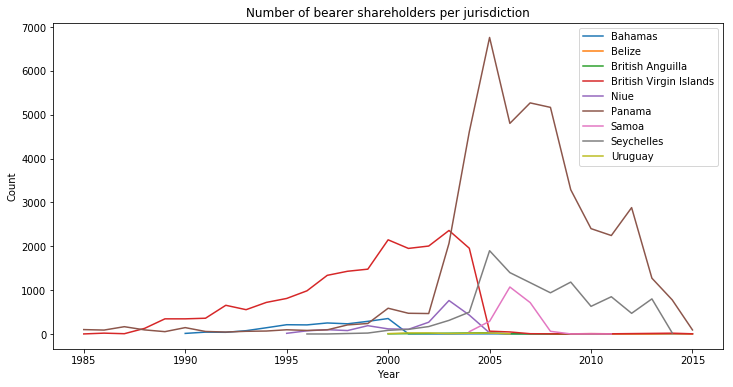

In [31]:
#Plot for each jurisdiction its number of bearer shareholders
juris_bearers = join2['jurisdiction_description'].unique()

plt.figure(figsize=(12,6))
for j in juris_bearers:
    bearer_j = join2[join2['jurisdiction_description']==j]
    plt.plot(bearer_j['incorporation_date'], bearer_j['count'])  
plt.title('Number of bearer shareholders per jurisdiction')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(juris_bearers)
plt.xticks(range(1980, 2020, 5))
plt.plot()

**We move on to Network Analysis**